# Electra Semantic Text Similarity
In this notebook, the Electra (electra-base-discriminator) model is used for finding  semantic text similarity between the pair of sentences.  The [STS_B benchmark](https://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) dataset is used for this work. This dataset consists of separate training, validation and test data. The work in this notebook contains two parts:
1. Sentence level embedding extraction from the pre-trained  bert model and apply cosine similarity between the pair sentences (No fine-tunned, but only using sentence vector representation from the pretrained model)

2. Fine-tune: The STS_B train dataset is used for fine tunning the model and validaiton dataset is used for model validation. And, the fine-tunned model is used to predict the test dataset.

In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import torch


In [3]:
#check version
print(torch.__version__)
print()
print(np.__version__, pd.__version__)
!python -V

1.11.0+cu113

1.21.6 1.3.5
Python 3.7.13


In [4]:
#check GPU is available or not 
if torch.cuda.is_available():

  device = torch.device("cuda")
  print('Found GPU :', torch.cuda.get_device_name(0))

else:
    print('Not found, use CPU instead')
    device = torch.device("cpu")

Found GPU : Tesla T4


In [5]:
#mount drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df_train = pd.read_csv("assin2-train.txt")
#df_dev = pd.read_csv("assin2-dev.txt")
#df_test = pd.read_csv("assin2-test.txt")

In [6]:
#load dataset
dataset_types = [ "df_dev_similaridade.csv", "df_test_similaridade.csv", "df_train_similaridade.csv",] # 3 datasets
col_names = ["sentence_1", "sentence_2","similaridade"] #columns names

#collect as a list of pandas dataframes
df_list = []
for dataset in dataset_types:
  df = pd.read_csv("/content/"+ dataset, 
                 delimiter=',' , 
                 header= None,
                 names= col_names
                )
  

  df_list.append(df)

#separate dataset (train, dev and test)
df_train = df_list[0]
df_dev = df_list[1]
df_test = df_list[2]

#show random 5 rows in each dataset (train, dev and test)
print("Show train_data shape: {}".format(df_train.shape))
print("Show dev_data shape: {}".format(df_dev.shape))
print("Show test_data shape: {}".format(df_test.shape))
print("Show Random 5 rows:")
df_train.sample(5)


Show train_data shape: (502, 3)
Show dev_data shape: (2002, 3)
Show test_data shape: (6502, 3)
Show Random 5 rows:


,sentence_1,sentence_2,similaridade
431.0,"Além dos jogadores, a FA decidiu denunciar Ars...",Tanto o Chelsea quanto o Arsenal também foram ...,0.9852630688268381
281.0,"Para relator, lei em vigor é muito rigorosa co...","Na avaliação do relator, a legislação em vigor...",0.965834538553668
364.0,O funkeiro Mr. Catra anunciou em seu Facebook ...,Catra também já garantiu que sabe o nome de to...,0.8807034727348073
313.0,Todo jogo para a Seleção Brasileira é para valer.,"Recentemente, nós tivemos um jogo contra eles ...",0.8130063380988367
362.0,"Depois, ele recebeu passe na esquerda, driblou...","No rebote, Lucas chutou e a bola entrou no âng...",0.9412635500313206


In [ ]:
#pd.set_option('display.max_rows', 10)
#pd.set_option('display.max_column', 10)

In [ ]:
#df_train_sentence_1 = df_train.iloc[0::2]

In [ ]:
#df_train_sentence_2 = df_train.iloc[1::2]

In [ ]:
#df_train_sentence_1.to_csv('df_train_sentence_1.csv', encoding='utf-8-sig')

In [ ]:
#df_train_sentence_2.to_csv('df_train_sentence_2.csv', encoding='utf-8-sig')

In [ ]:
#df_dev_sentence_1 = df_dev.iloc[0::2]

In [ ]:
#df_dev_sentence_2 = df_dev.iloc[1::2]

In [ ]:
#df_dev_sentence_1.to_csv('df_dev_sentence_1.csv', encoding='utf-8-sig')

In [ ]:
#df_dev_sentence_2.to_csv('df_dev_sentence_2.csv', encoding='utf-8-sig')

In [ ]:
#df_test_sentence_1 = df_test.iloc[0::2]

In [ ]:
#df_test_sentence_2 = df_test.iloc[1::2]

In [ ]:
#df_test_sentence_1.to_csv('df_test_sentence_1.csv', encoding='utf-8-sig')

In [ ]:
#df_test_sentence_2.to_csv('df_test_sentence_2.csv', encoding='utf-8-sig')

# **Text Preprocessing**
Prepare text data according to Electra format as same as BERT. We have to tokenize the text sequences/sentences as per the Electra requirements before feeding them into Model. For this, we will use ElectraTokenizer from hugging face.

In [8]:
#tranformer library from Hugging face
#!pip install transformers

In [7]:
#import libraries from hugging face
from transformers import ElectraModel, ElectraTokenizer, BertTokenizer, BertModel
tokenizer= ElectraTokenizer.from_pretrained('google/electra-base-discriminator') #initiate tokenizer 

# Hugging Face Tokenizer
Example of  tokenizer 

In [8]:
#text
text = df_train.sentence_1[0]
print('Raw text: {}'.format(text))

#Tokenize the text
tokenize = tokenizer.tokenize(text)
print('Tokenized text: {}'.format(tokenize))

#encode text
input_ids =tokenizer.encode(text) # add '[CLS]' and '[SEP]' tokens
print('Encoded text: {}'.format(input_ids))

#convert input_ids back to tokens
ids_to_tokens= tokenizer.convert_ids_to_tokens(input_ids)
print('ids_to_tokens: {}'.format(ids_to_tokens))

#convert tokens back to input_ids
ids_to_tokens= tokenizer.convert_tokens_to_ids(ids_to_tokens)
print('ids_to_token: {}'.format(ids_to_tokens))

Raw text: sentence_1
Tokenized text: ['sentence', '_', '1']
Encoded text: [101, 6251, 1035, 1015, 102]
ids_to_tokens: ['[CLS]', 'sentence', '_', '1', '[SEP]']
ids_to_token: [101, 6251, 1035, 1015, 102]


#Count tokens in Sequences
Since we have to have equal length of every sequence, check the maximun token length in every sentences in all datasets and  we will use this max length for all sequences as fix-length size while doing sequence padding.

Or, we may use the other  best max-length. So that there is no risk of loss of much tokens while doing truncating and not require much of padding  in the sequences.

In [9]:
#counts tokens in sequences
dataset_all = [df_train.sentence_1, df_train.sentence_2, df_dev.sentence_1, df_dev.sentence_2,df_test.sentence_1,df_test.sentence_2] #list of all dataset
dataset_type_name = ['df_train.sentence_1', 'df_train.sentence_2', 'df_dev.sentence_1', 'df_dev.sentence_2', 'df_test.sentence_1', 'df_test.sentence_2'] #name of dataset

max_len = 0 # tokens max count in overall datasets
token_len_list = [] #store token counts for each dataset
higest_token_len = {} # store higest token counts in each dataset


#zip and iterate over all datasets
for nam_data, each_dataset in zip(dataset_type_name, dataset_all):
  token_len_dataset = [] #store each sequence count of each dataset
  max_len_seq= 0 # max count of  sequence in each dataset 

  #iterate over sequences in each dataset
  for sent in each_dataset:
    tokens = tokenizer.encode(sent) #tokenize
    tokens_len = len(tokens) # count length
    token_len_dataset.append(tokens_len) 
    
    
    # keep tracking the higest counts in each dataset
    if tokens_len > max_len_seq:
      max_len_seq = tokens_len
    
    #higest count overall dataset
    if max_len_seq > max_len:
      max_len = max_len_seq
       
  higest_token_len[nam_data] =  max_len_seq 
  token_len_list.append(token_len_dataset)

print("Higest tokens number in 3 datasets: %s ." % (max_len))
print()
print('Higest counts in each dataset:\n')
higest_token_len



Higest tokens number in 3 datasets: 74 .

Higest counts in each dataset:



{'df_dev.sentence_1': 74,
 'df_dev.sentence_2': 54,
 'df_test.sentence_1': 56,
 'df_test.sentence_2': 56,
 'df_train.sentence_1': 51,
 'df_train.sentence_2': 47}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

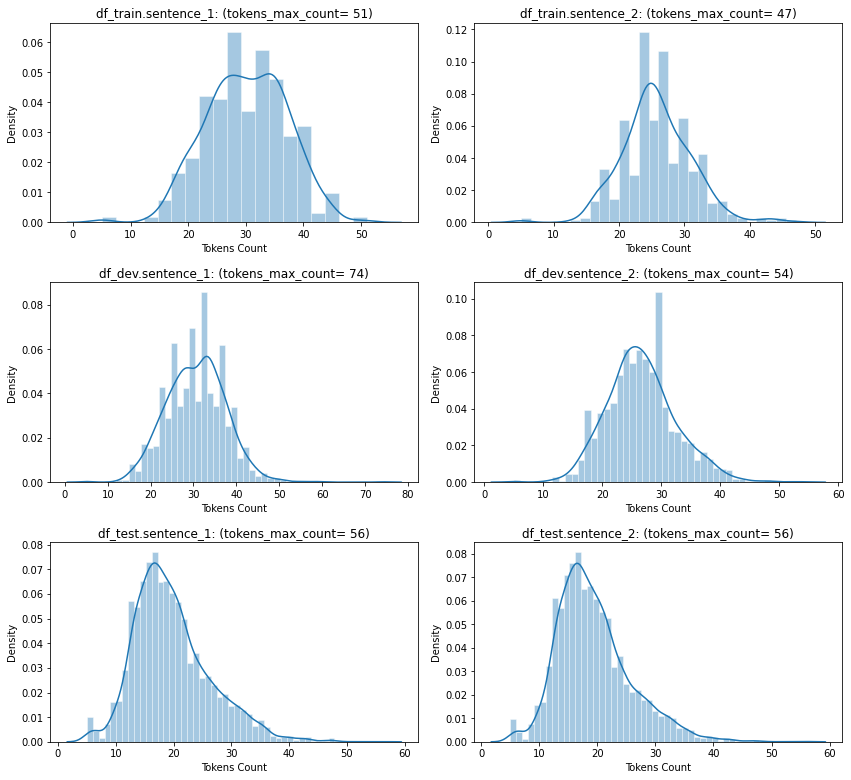

In [10]:
#Plot the diagram to show the tokens' length distribution in dataset
import seaborn as sns
from matplotlib import pyplot as plt

# data to plot
data = token_len_list 

#creates subplots  with nrows=3, ncols=2
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,11))
sns.set(style='darkgrid') #set plot style

#change 'axes' to 1d, zip and emumerate
for i, (name, axe)  in enumerate(zip(dataset_type_name, axes.flatten())):
  sns.distplot(token_len_list[i], axlabel ='Tokens Count', ax=axe) #distplot type
  name = name + ': (tokens_max_count= '+ str(higest_token_len[name]) + ')' #title (for example: df_train.sentence_1:(max_count=70))
  axe.set_title(name) #title for each suplots
fig.tight_layout()#fit nicely
plt.show()

**Observation**:  The max tokens count  in a sequence is 70 in all dataset. Among all dataset, the train dataset(both in sentence1 and sentence 2) have higer tokens count of 70 and 63 respectively. But, the majority of tokens length are about 40 counts. 

So, this gives us the good idea for selecting the max-length of tokens in a sequence.  We may put our max-length of 60, so that we will not truncate more tokens(loss information) and also don't have to do more padding.

But, we may use 120 tokens length (double of a single sequence) for the model architecure where a pair of sentence are required to feed together.

# Part-1: Sentence Level Embedding Extraction
For Sentence Embedding Extraction, last 4 hidden layers are concatenated and mean pooling of words in a sequence/sentence is done. So, the final dimension of a sentence vector representation is 768*4 =3072.

In [11]:
#function to extract sentence level embedding from Bert Model
def sent_embedding(sent, model):
  """
   Concatenate from last 4 layers and Mean pooling of words in sentences

  Args:
     sent: list of sentences
     model: BERT pre-trained model

  Returns:
     sent_embedding: 2d tensor 

  """
  # tokenize  each sequence into fix-length size of 70 tokens
  tokens = tokenizer.batch_encode_plus( sent,
                                       max_length= 70, # each sequence size
                                       padding= 'max_length', # padding
                                       add_special_tokens = True, # add '[CLS]'and '[SEP]'
                                       return_attention_mask = True, # attention mask 
                                       return_tensors='pt',  # return PyTorch tensors
                                       truncation=True #truncation
                                      )
   
  

  #feed input_ids to BERT model
  with torch.no_grad():  # reduces memory consumption
        outputs = model(tokens['input_ids'], tokens['attention_mask'] ) # feed input_ids, attention_mask
        hidden_states = outputs[1] # all hidden layers

  concat_embeding = torch.cat(tuple([hidden_states[i] for i in [-4,-3,-2,-1]]), dim = 2) #concatenate last 4 hidden layers
  print('Dimension after Last_four_layers concatenation: ',concat_embeding.shape )
  padded = tokens['attention_mask'].unsqueeze(2) # insert size one at 2 position
  mul_out = torch.mul(concat_embeding, padded)# make zeros vector for paddding tokens
  sent_embeding = mul_out.mean(dim=1) # average pooling  of tokens
  print('Sentence embedding dimension: ',sent_embeding.shape )
   
  return sent_embeding



In [12]:
# initiate the pre-trained model
model = ElectraModel.from_pretrained( 'google/electra-base-discriminator',
                                     output_hidden_states = True # return all hidden-states
                                    )
#put model in evaluation
model.eval()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [13]:
#check paramerts in model
params = list(model.named_parameters())
#len(model.state_dict())
print('total different named paramerters: {}'.format(len(params)))
print()
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print()
print()
for p in params[-16:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

total different named paramerters: 197

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)


encoder.layer.11.attention.self.query.weight              (768, 768)
encoder.layer.11.attention.self.query.bias                    (768,)
encoder.layer.11.attention.self.key.weight                (768, 768)
encoder.layer.11.attention.self.key.bias                      (768,)
encoder.layer.11.attention.self.value.weight              (768, 768)
encoder.layer.11.attention.self.value.bias                    (768,)
encoder.layer.11.attention.output.dense.weight            (768, 768)
encoder.layer.11.attention.output.dense.bias                  (768,)
encoder.layer.11.attention.output.LayerNorm.weight           

# Extract Sentence embedding
Now, lets extract sentence level vector representation for all datasets.

In [14]:
%%time
#dev dataset
df_dev_sentence_1 = sent_embedding(df_dev.sentence_1, model)
df_dev_sentence_2 = sent_embedding(df_dev.sentence_2, model)

Dimension after Last_four_layers concatenation:  torch.Size([2002, 70, 3072])
Sentence embedding dimension:  torch.Size([2002, 3072])
Dimension after Last_four_layers concatenation:  torch.Size([2002, 70, 3072])
Sentence embedding dimension:  torch.Size([2002, 3072])
CPU times: user 11min 9s, sys: 13.1 s, total: 11min 22s
Wall time: 11min 21s


In [ ]:
%%time
#test dataset
df_test_sentence_1 = sent_embedding(df_test.sentence_1, model)
df_test_sentence_2 = sent_embedding(df_test.sentence_2, model)

In [ ]:
%%time
#train dataset
train_embed_sentence_1 =  []
train_embed_sentence_2 =  []

#make batches
for x in range(0, df_train.shape[0], 1500):
  embed_1= sent_embedding(df_train.sentence_1[x: x+1500], model)
  embed_2= sent_embedding(df_train.sentence_2[x: x+1500], model)
  train_embed_sentence_1.extend(embed_1)
  train_embed_sentence_2.extend(embed_2)

#sentence level vector represetnation in train dataset
df_train_sentence_1 = torch.stack(train_embed_sentence_1) # change list of tensors >>> 2d tensor
df_train_sentence_2 = torch.stack(train_embed_sentence_2) # change list of tensors >>> 2d tensor


# Calculate Cosine Similarity
Now, sentence level vector representation of each pair sentence is used to find the cosine similarity. Cosine similarity is calculated on all 'dev' and 'test' datasets.

In [ ]:
from scipy.spatial.distance import cosine #cosine distance
from sklearn.preprocessing import MinMaxScaler # minmax scaling
from scipy.stats import pearsonr # pearson correlation
from scipy.stats import spearmanr # spearman correlation
from collections import defaultdict #store scores

In [ ]:
#function to calculate similarity score 
def calc_similarity_score(embed_1, embed_2):
  """
  Args:
    embed_1(numpy array): first sentence embedding
    embed_2(numpy array): second sentence embedding

  Return:
    scaled_cosine_score(list) : cosine score between embed_1 and embed_2 
    with range (0,5)


  """
  
  #collect similarity score
  cosine_sim_score = []
  
  for x,y in zip(embed_1, embed_2):

    distance = cosine(x, y) # cosine distance
    cosine_sim = 1 - distance # cosine similarity
    cosine_sim_score.append(cosine_sim) 

  


  #scaled the similarity score to (0,5)
  scaler = MinMaxScaler(feature_range=(0,5)) # initiate minmaxscaler
  scaled_cosine_score = scaler.fit_transform(np.transpose([cosine_sim_score])) #scaled to (0,5)
  
  return scaled_cosine_score.round(3)
  

In [ ]:
#Pearson and Spearman score
first_sent_embd = [df_train_sentence_1, df_dev_sentence_1, df_test_sentence_1] #first sentence embedding
second_sent_embd = [df_train_sentence_2, df_dev_sentence_2, df_test_sentence_2] #second sentence embedding
gold_labels = [df_train.loc[:,'score(0-5)'].values, df_dev.loc[:,'score(0-5)'].values, df_test.loc[:,'score(0-5)'].values ] #gold scores
data_type = ['Train', 'Validation', 'Test'] #datasets names

pear_spear_score = defaultdict(list) #store scores

#zip and enumerate 'first_sent_embd' and 'second_sent_embd'
for i, (first_sent, second_sent) in enumerate(zip(first_sent_embd,second_sent_embd)):
  cosine_sim_score = calc_similarity_score(first_sent, second_sent) #cosine similarity score
  cosine_sim_score = cosine_sim_score.flatten()# change to 1d

  person_score, _ = pearsonr(gold_labels[i], cosine_sim_score) #pearson score
  pear_spear_score['pearson'].append(person_score)
  

  sperman_score, _ = spearmanr(gold_labels[i], cosine_sim_score)#spearman score
  pear_spear_score['spearman'].append(sperman_score)

  print(data_type[i], 'data: ')
  print('=='*6)
  print("Pearson score: {} \nSpearman score: {}".format(person_score, sperman_score))
  print()
  


KeyError: ignored

In [ ]:
#show in panda dataframe
df_score = pd.DataFrame.from_dict(pear_spear_score,
                          orient='index',
                          columns=['Train', 'Dev', 'Test']
                          )
df_score.drop('Train', 1) #only train and test 


NameError: ignored

# Part-2: Fine-Tune ELECTRA
The custom model is defined using pytorch nn.module. And, The pre-trained ELECTRA(electra-base-discriminator) model is fine-tunned with STS-b 'train' dataset and evulate on 'dev' test

In [ ]:
#import necessary libraries
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader #pytorch dataset and dataloader
from transformers import  AdamW, get_linear_schedule_with_warmup #optimizer and learning rate scheduler
from collections import defaultdict  #store scores

# Custom Model
The two different network stuctures are tried  for fine-tuning the pre-trained model. They are as follows:

1. Siamese Network: In this Siamese Network structure, two different sentences(a pair of sentences) are encoded separetely meaning they are encoded one by one, and their final vecotors are used to calculate the cosine similarity.  The output layer is just the cosine similairty. No additonal layers.  The vector representation of a sentence is the concatenation of the last 4 hidden layers, and mean pooling of the tokens in a inputed sequence. 

2. Regression Model: In this fine-tuning, the Linear Regression output layer is added on the top of Bert. The two sentences(a pair of sentences) are feeded and encoded together. And, the final output is the regression ouput.

The Mean Square Error(MSE) Loss is used as loss function  for both the Netowrk structures.

In [ ]:
#define custom model with cosine-similarity output
class ElectraSentenceSimilarityModelCos(nn.Module):
  """
  Model extracts sentence embedding of a pair of sentences one by one and
  return  cosine similarity between them.
  """
  
  def __init__(self):
    super().__init__()
    self.electra = ElectraModel.from_pretrained( 'google/electra-base-discriminator',
                                     output_hidden_states = True) # all hidden-states
    self.cosine_sim = nn.CosineSimilarity(dim=1, eps=1e-6)#cosine similarity
   
  #feed a pair of sentences' input_ids and attention_ids 
  def forward(self, input_ids_1, atten_ids_1, input_ids_2, atten_ids_2):
    """
        Args:
          input_ids_1(tensor) : input_ids of first sentence
          input_ids_2(tensor) : input_ids of second sentence
          atten_ids_1(tensor): attention_mask of first sentence
          atten_ids_2(tensor): attention_mask of second sentence
       Returns:
          cosine_score(2d tensor): Cosine similarity between a pair of sentences
    """
    
    #first sentence embedding
    output_1 = self.electra(input_ids = input_ids_1, attention_mask = atten_ids_1)
    hidden_states_1 = output_1[1] # all layers hidden-states
    concat_embeding_1 = torch.cat(tuple(hidden_states_1[i] for i in [-4,-3,-2,-1]), dim = 2) # concatenate last four hidden layers
    padded_1 = atten_ids_1.unsqueeze(2) #insert size one at position 2
    mul_out_1 = torch.mul(concat_embeding_1, padded_1)#make zeros vector for paddding tokens
    sent_embeding_1 = mul_out_1.mean(dim=1) # pooling average of tokens
  
    #second sentence embedding
    output_2 = self.electra(input_ids = input_ids_2,attention_mask = atten_ids_2)
    hidden_states_2 = output_2[1]
    concat_embeding_2 = torch.cat(tuple(hidden_states_2[i] for i in [-4,-3,-2,-1]), dim = 2) # last four layers
    padded_2 = atten_ids_2.unsqueeze(2) 
    mul_out_2 = torch.mul(concat_embeding_2, padded_2)
    sent_embeding_2 = mul_out_2.mean(dim=1)

    #calculate cosine similarity
    cosine_score = self.cosine_sim(sent_embeding_1, sent_embeding_2)
    return cosine_score
    
  

In [ ]:
#define custom model with Regression output
class ElectraSentenceSimilarityModelReg(nn.Module):
  """This model takes a pair of sentences at a time and returns regression output """
  
  def __init__(self):
    super().__init__()
    self.electra = ElectraModel.from_pretrained( 'google/electra-base-discriminator',
                                     output_hidden_states = True) # all hidden-states
    self.drop = nn.Dropout(p=0.1) #droupout
    self.regression = nn.Linear(self.electra.config.hidden_size,1) #output regresion layer
      
  #forward pass
  def forward(self, input_ids, attention_masks, token_type_ids):
    """
      Args:
          input_ids_1(tensor) : input_ids of a pair of sentence
          attention_mask_1(tensor): attention_mask of a pair of sentence

       Returns:
          regre_output(1d tensor) : regression output
    """
  
    #initiate pre-trained model
    electra_output = self.electra( input_ids = input_ids, attention_mask = attention_masks,token_type_ids = token_type_ids)
    #hidden_state = electra_output[0]# last_hidden_state
    hidden_state = electra_output[0][:,0,:] #['CLS'] token of last hidden_state
    drop_out =  self.drop(hidden_state) 
    regre_output =  self.regression(drop_out)# apply linnear tranformation
    return regre_output

  
    

In [ ]:
#define custom model with Regression output
class ElectraBertSentenceSimilarityModelReg(nn.Module):
  """
  This model  is the combination of Bert and Electra models. It takes a pair of 
  sentences at a time and returns regression output 
  """
  
  def __init__(self):
    super().__init__()
    self.electra = ElectraModel.from_pretrained( 'google/electra-base-discriminator',
                                     output_hidden_states = True) # pretrained Electra
    self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True )#pretrained bert 
    self.drop = nn.Dropout(p=0.1) #droupout
    self.regression = nn.Linear( self.electra.config.hidden_size*2,1) #output regresion layer
      
  #forward pass
  def forward(self, input_ids, attention_masks, token_type_ids):
    """
      Args:
          input_ids_1(tensor) : input_ids of a pair of sentence
          attention_mask_1(tensor): attention_mask of a pair of sentence

       Returns:
          regre_output(1d tensor) : regression output
    """

    #initiate pre-trained bert model
    bert_output = self.bert( input_ids = input_ids, attention_mask = attention_masks,token_type_ids = token_type_ids)
    hidden_state_bert = bert_output[0][:,0,:]# ['CLS']  last_hidden_state
    #drop_out_br =  self.drop(hidden_state_bert) 
   
    
    #initiate pre-trained electra model
    electra_output = self.electra( input_ids = input_ids, attention_mask = attention_masks,token_type_ids = token_type_ids)
    #hidden_state = electra_output[0]# last_hidden_state
    hidden_state_electra = electra_output[0][:,0,:] #['CLS'] token of last hidden_state
    #drop_out_el =  self.drop(hidden_state_electra) 

    #concatenation  bert and electra embedding
    #bert_electra = torch.cat((drop_out_br, drop_out_el), dim=1) 
    bert_electra = torch.cat((hidden_state_bert, bert_electra), dim=1) 
    bert_electra = self.drop(bert_electra)
    regre_output =  self.regression(bert_electra)# apply linnear tranformation'''
    return regre_output
  
    

# Create Pytorch Dataset
Pytorch dataset is created that returns input_ids, attention_mask, token_type_ids, and gold_score from each input sequence.

Since  we are trying two different model network architectures for fine-tuning, the way of feeding the pair of sentences are different from one architecture to another. For example, in a regression model, we feed a pair of sentences together while in Siamese network model, we feed one sentence and take sentence level embedding and same goes to its pair sentence. 

Thus, a function  is written that returns the pytorch dataset which fit for both the model architectures.

In [ ]:
#define function to pytorch Dataset
class SimilarityDataset(Dataset):
  """ 
  Pytorch dataset that returns input_ids, attension_mask a pair of sentences, and 
  gold_score  of STS-B dataset. Dataset is return based on the model type 
  i.e. either ('regresion' or 'cosine'). Default is Siamese network structure.
  """

  def __init__(self, sent_1s, sent_2s, scores, tokenizer, max_len, model_type = 'cosine'):
    """
     Args:
       sent_1s(numpy array): Array of first sentences
       sent_2s(numpy array): Array of second sentences
       scores(float): Gold score (0-5)
       tokenizer: Higging Face Bert Tokenizer
       max_len(int): Maximun token length
       model_type(str): type of model architecture to calculate 
       ouput(for example, 'regression' or 'cosine')
      
    """
    self.sent_1s = sent_1s
    self.sent_2s = sent_2s
    self.scores = scores
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.model_type = model_type


  def __len__(self):
    return len(self.sent_1s) #total no. of samples


  def __getitem__(self, item):
    first_sent = self.sent_1s[item]  #first sentencs
    second_sent = self.sent_2s[item] #second sentence
    score = self.scores[item]

    #print('model_type is: {}'.format(self.model_type))
    # model type is 'Siamese Network'
    if self.model_type == 'cosine':

      #encode first sentence
      first_sent_encoding = self.tokenizer( first_sent,
                                            add_special_tokens=True, #add ['CLS'] and ['SEP']
                                            max_length=self.max_len, # set max len for padding
                                            return_token_type_ids=False, #set false to segment_ids
                                            padding='max_length', # padding
                                            return_attention_mask=True,  # return attention mask
                                            return_tensors='pt', # pytorch tensor
                                            )
      


      #encode second sentence
      second_sent_encoding = self.tokenizer( second_sent,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            return_token_type_ids=False,
                                            padding= 'max_length',
                                            return_attention_mask=True,
                                            return_tensors='pt',
                                            )
      
      return {
          'input_ids' :{ 
              'first_sent' : first_sent_encoding['input_ids'].flatten(),
              'second_sent' : second_sent_encoding['input_ids'].flatten()},

          'attention_ids' :{
              'first_sent' :first_sent_encoding['attention_mask'].flatten(),
              'second_sent' :second_sent_encoding['attention_mask'].flatten()},

          'score' : torch.tensor(score)}



    #if model's out is regression type
    else:

      #encode input sequences
      sent_encoding = self.tokenizer(   first_sent, second_sent,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        return_token_type_ids=True,
                                        padding= 'max_length',
                                        truncation = True,
                                        return_attention_mask=True,
                                        return_tensors='pt',
                                      )
      return {
            'input_ids' : sent_encoding['input_ids'].flatten(),
            'attention_ids' : sent_encoding['attention_mask'].flatten(),
            'token_type_ids' : sent_encoding['token_type_ids'].flatten(),
            'score' : torch.tensor(score),}

    


# Pytorch Data Loader
It provides an iterable over the given dataset.

In [ ]:
#define pytorch data loader
def pytorch_data_loader(df, tokenizer, max_len, batch_size, model_type='cosine'):
  """
    Agrs:
       df(panda dataframe): dataset
       tokenizer(Hugging face tokeniser): Bert Tokonizer
       max_len(int): Maximun tokens length in a sequence/sentence
       batch_size(int): Number of samples in a batch
       model_type(str): type of model architecture to calculate 
       ouputs(for example, 'regression' or 'cosine')

    Return:
      Dataloader(pytorch dataloader): Dataset with given batch size
  """
  dataset = SimilarityDataset(
      sent_1s =df.sentence_1.to_numpy(), #first sequence
      sent_2s =df.sentence_2.to_numpy(), #second sequence
      scores =df.loc[:,'scaled_score(0-1)'].to_numpy(), #gold score
      tokenizer=tokenizer, #hugging face tokenizer
      max_len=max_len, #max length for padding
      model_type = model_type # return dataset as per model type
  )

  return DataLoader( 
      dataset,
      batch_size=batch_size,
      shuffle= True
  )

In [ ]:
#define model training function
def model_train(model, dataloader, device, loss_fun, optimizer, scheduler, model_type):
  """
     Args:
       model: Custom model
       dataloader: Pytorh data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       optimizer: optimizer (Adamw)
       scheduler: learning rate schedule
       model_type(str): type of model architecture('regression' or 'cosine')

    Returns:
       training loss, and Pearson correlation between gold_score and predicted score
       
  """
  print('Model is training based on {} ouput!!!'.format(model_type))

  #put model in training mode
  model.train()

  losses = [] # store loss from each batch
  pearson_score = [] #pearson score from each batch

  #Siamese Model type(Cosine output)
  if model_type == 'cosine':
  
    #iterate over each batch of training data
    for batch in dataloader:

      #first sent
      input_ids_1 = batch['input_ids']['first_sent'].to(device)
      atten_ids_1= batch['attention_ids']['first_sent'].to(device)
      #second sent
      input_ids_2 = batch['input_ids']['second_sent'].to(device)
      atten_ids_2 = batch['attention_ids']['second_sent'].to(device)

      #gold score
      gold_score = batch['score'].to(device).float() # change to float dtype as same as model output
      
      #clear previously calculated gradients
      model.zero_grad()

      #model forward pass
      output = model(input_ids_1, atten_ids_1, input_ids_2, atten_ids_2) # output dtype --> float tenosr 
      
      #Calculate Pearson Correlation score
      p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
      pearson_score.append(p_score[0])
      
      #perform loss
      loss = loss_fun(output, gold_score)
      losses.append(loss.item()) 

      loss.backward() # perform backward pass to calculate gradients
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# clip the norm of the gradients to 1.0.
      optimizer.step() #update parameters
      scheduler.step() #update learning rate
      
    return np.mean(losses), np.mean(pearson_score)

  #Regression model type
  elif model_type == 'regression':

    #iterate over each batch of training data
    for batch in dataloader:
      
      #Input sequence 
      input_ids = batch['input_ids'].to(device)
      atten_ids = batch['attention_ids'].to(device)
      tok_type_ids = batch['token_type_ids'].to(device)

      #gold score
      gold_score = batch['score'].to(device).float() # change to float dtype as same as model output
      
      #clear previously calculated gradients
      model.zero_grad()

      #model forward pass
      output = model(input_ids, atten_ids, tok_type_ids) # output dtype --> float tenosr 
      output = output.flatten()
      
      #Calculate Pearson Correlation score
      p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
      pearson_score.append(p_score[0])
      
      #perform loss
      loss = loss_fun(output, gold_score)
      losses.append(loss.item()) 

      loss.backward() # perform backward pass to calculate gradients
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)# clip the norm of the gradients to 1.0.
      optimizer.step() #update parameters
      scheduler.step() #update learning rate
    return np.mean(losses), np.mean(pearson_score)

  else:
    print('Pleae specify the model type for training !!!')

  


In [ ]:
# define evaluation function
def model_eval(model, dataloader, device, loss_fun, model_type):
  """
     Args:
       model: Custom model
       dataloader: pytorch data loader
       device: device to compute
       loss_fun:  loss function( MES loss)
       
    Returns:
       Evaluation loss, and Pearson & Spearman correlation between gold_score and predicted score
       
  """
  #print('Model is validation based on {} ouput!!!'.format(model_type))

  #put model in evaluation mode
  model.eval()
  losses = []
  pearson_score = []
  sparman_score = []
  
  #tell model not to compute or store gradients
  with torch.no_grad():
    
    #Siamese model type(cosine)
    if model_type == 'cosine':
      
      #each batch of evaluation data
      for batch in dataloader:
        #first sentence
        input_ids_1 = batch['input_ids']['first_sent'].to(device)
        atten_ids_1 = batch['attention_ids']['first_sent'].to(device)

        #second sentence
        input_ids_2 = batch['input_ids']['second_sent'].to(device)
        atten_ids_2 = batch['attention_ids']['second_sent'].to(device)

        #gold score
        gold_score = batch['score'].to(device).float() # change to float dtype as same as model output

        #model forward pass
        model = model
        output = model(input_ids_1, atten_ids_1, input_ids_2, atten_ids_2) # output type --> float tensor 
        output = output.flatten()

        #perform loss
        loss = loss_fun(output, gold_score)
        losses.append(loss.item()) 
        
        #Calculate Pearson Correlation score
        p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
        pearson_score.append(p_score[0])

        #Calculate Spearman Correlation score
        sp_score = spearmanr(output.detach().cpu(), gold_score.detach().cpu())
        sparman_score.append(sp_score[0])
      return np.mean(losses), np.mean(pearson_score), np.mean(sparman_score)
    

    #regression model type
    elif model_type == 'regression':

      #each batch of evaluation data
      for batch in dataloader:
        #first sentence
        input_ids = batch['input_ids'].to(device)
        atten_ids = batch['attention_ids'].to(device)
        tok_type_ids = batch['token_type_ids'].to(device)

        #gold score
        gold_score = batch['score'].to(device).float() # change to float dtype as same as model output

        #model forward pass
        model = model
        output = model(input_ids, atten_ids, tok_type_ids) # output type --> float tensor 
        output= output.flatten()
        
        #perform loss
        loss = loss_fun(output, gold_score)
        losses.append(loss.item()) 
        
        #Calculate Pearson Correlation score
        p_score = pearsonr(output.detach().cpu(), gold_score.detach().cpu())
        pearson_score.append(p_score[0])

        #Calculate Spearman Correlation score
        sp_score = spearmanr(output.detach().cpu(), gold_score.detach().cpu())
        sparman_score.append(sp_score[0])

      return np.mean(losses), np.mean(pearson_score), np.mean(sparman_score)

    else:
      print('Please specify the model type for evaluation !!!')

  


# Re-scaled gold score from (0-5) to (0,1)
Before making the Data to Pytorch Dataloader, lets re-scaled the 'gold score' to (0,1). This is done because to make the same range as the  cosine similarity score i.e.(0,1). So, it will be  easy to calculate the loss during the model training.

In [ ]:
#re-scale to all datasets
df_train['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_train[['score(0-5)']])
df_dev['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_dev[['score(0-5)']])
df_test['scaled_score(0-1)'] = MinMaxScaler(feature_range=(0,1)).fit_transform(df_test[['score(0-5)']])


In [ ]:
#Create data loader for Regression model
BATCH_SIZE = 16
train_data_loader_reg = pytorch_data_loader( df_train.sample(frac=1.0), tokenizer, 120, BATCH_SIZE, 'regression') # train data loader
dev_data_loader_reg = pytorch_data_loader(df_dev, tokenizer, 120, BATCH_SIZE , 'regression', )# dev data loader
test_data_loader_reg = pytorch_data_loader(df_test, tokenizer, 120, BATCH_SIZE, 'regression' )# test data loader

In [ ]:
#Create data loader for  cosine similarity output
train_data_loader_cos = pytorch_data_loader( df_train.sample(frac=1.0), tokenizer, 70, BATCH_SIZE) # train data loader
dev_data_loader_cos= pytorch_data_loader(df_dev, tokenizer, 70, BATCH_SIZE )# dev data loader
test_data_loader_cos = pytorch_data_loader(df_test, tokenizer, 70, BATCH_SIZE)# test data loader


In [ ]:
#chaek batch of dataloader
data = next(iter(train_data_loader_reg))
data


{'attention_ids': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'input_ids': tensor([[  101, 22226,  2006,  ...,     0,     0,     0],
         [  101,  8112,  2000,  ...,     0,     0,     0],
         [  101,  5920,  9472,  ...,     0,     0,     0],
         ...,
         [  101, 19463,  2088,  ...,     0,     0,     0],
         [  101, 10079, 14369,  ...,     0,     0,     0],
         [  101,  1037,  2450,  ...,     0,     0,     0]]),
 'score': tensor([0.8000, 0.4400, 0.5600, 0.7200, 0.8400, 0.0400, 0.9600, 0.6400, 0.4000,
         0.6000, 0.6000, 0.4400, 0.5600, 0.0000, 0.2400, 0.8800],
        dtype=torch.float64),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 

# Model Training And Evaluation

In [ ]:
#initiate model
custom_model_cos = ElectraSentenceSimilarityModelCos()
custom_model_cos = custom_model_cos.to(device)

custom_model_reg = ElectraSentenceSimilarityModelReg()
custom_model_reg = custom_model_reg.to(device)

custom_model_BertElectra = ElectraBertSentenceSimilarityModelReg()
custom_model_BertElectra = custom_model_BertElectra.to(device)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['electra.embeddings_project.weight', 'electra.embeddings_project.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#setup hyper-parameter
EPOCHS = 10 # Training epoch
#optimizer_cos =AdamW( custom_model_cos.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-6) #optimizer for cosine ouput
#optimizer_reg =AdamW(custom_model_reg.parameters(), lr=1e-4,betas=(0.9, 0.999), eps=1e-6) #optimizer for regression output
optimizer_BertElec =AdamW(custom_model_BertElectra.parameters(), lr=1e-4,betas=(0.9, 0.999), eps=1e-6) #optimizer for regression output
total_steps = len(train_data_loader_cos) * EPOCHS # total number training steps

#learning rate scheduler
scheduler_cos = get_linear_schedule_with_warmup(  
  optimizer_cos,  
  num_warmup_steps=0,
  num_training_steps=total_steps
)  

scheduler_reg = get_linear_schedule_with_warmup(  
  optimizer_reg,  
  num_warmup_steps=0,
  num_training_steps=total_steps
)  

scheduler_BertElec = get_linear_schedule_with_warmup(  
  optimizer_BertElec,  
  num_warmup_steps=0,
  num_training_steps=total_steps
)  

#MSE loss function
loss_fn = nn.MSELoss().to(device)

#model type
model_type = ['regression', 'cosine']


####Cosine Similarity Output Model

In [ ]:
%%time
#Training process start for Cosine similarity output model
epochs_score = defaultdict(list) #store scores
val_score = 0 #validation score

for epoch in range(EPOCHS):
  print('Epoch {:}/{:}'.format(epoch + 1, EPOCHS))
  print('=='*5)
  print()
  
  #model training initiate
  train_loss, train_Pearson_score = model_train(custom_model_cos, train_data_loader_cos, device, loss_fn, optimizer_cos, scheduler_cos, model_type[1])
  print('Train loss is: {}, train_Pearson_score is {}'.format(train_loss,train_Pearson_score))
  #store values
  epochs_score['train_loss'].append(train_loss) #train losss
  epochs_score['train_Pearson_score'].append(train_Pearson_score) # pearson correlation


  #model validatiaon initiate
  val_loss, val_Pearson_score, val_Spearman_score = model_eval(custom_model_cos, dev_data_loader_cos, device, loss_fn, model_type[1])
  print('Validation loss is: {}, Validation_Pearson_score is {}'.format(val_loss,val_Pearson_score))
  print()
  #store values
  epochs_score['val_loss'].append(val_loss) #train losss
  epochs_score['val_Pearson_score'].append(val_Pearson_score) # pearson correlation
  epochs_score['val_Spearman_score'].append(val_Spearman_score) # Spearman correlation

  #save model with high validaiton score
  if val_Pearson_score >  val_score:
    val_score = val_Pearson_score
    torch.save(custom_model_cos.state_dict(), 'Electra_cos_best_model.bin')

print()
print('Training completed......')


Epoch 1/10

Model is training based on cosine ouput!!!
Train loss is: 0.09950532399945788, train_Pearson_score is 0.16991115754385216
Validation loss is: 0.083480271094657, Validation_Pearson_score is 0.5695479550593343

Epoch 2/10

Model is training based on cosine ouput!!!
Train loss is: 0.0635827765489618, train_Pearson_score is 0.5209959026757578
Validation loss is: 0.05338765228999422, Validation_Pearson_score is 0.7019368329109742

Epoch 3/10

Model is training based on cosine ouput!!!
Train loss is: 0.04079828499298957, train_Pearson_score is 0.7244741614454837
Validation loss is: 0.0491655087296633, Validation_Pearson_score is 0.7713373979989414

Epoch 4/10

Model is training based on cosine ouput!!!
Train loss is: 0.02426913876293434, train_Pearson_score is 0.8466110943335656
Validation loss is: 0.039651960530813705, Validation_Pearson_score is 0.7915242242566503

Epoch 5/10

Model is training based on cosine ouput!!!
Train loss is: 0.015391676352980237, train_Pearson_score is

In [ ]:
#clear unused GPU
with torch.no_grad():
  torch.cuda.empty_cache()

####Plot Model Learning Curve

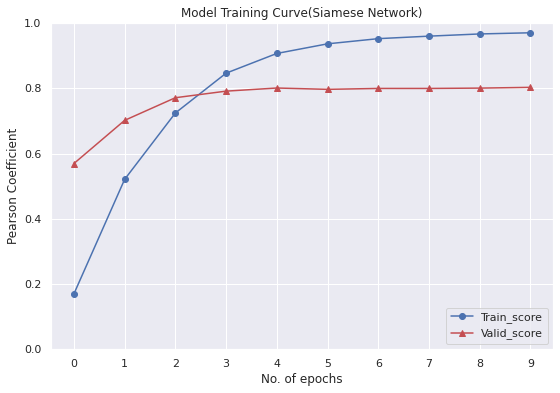

In [ ]:
#plot training and validation curve 
import matplotlib.pyplot as plt
import seaborn as sns
train_score = epochs_score['train_Pearson_score'] # train_score
valid_score = epochs_score['val_Pearson_score'] # valid_score
 

sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score ,'o-b', label= 'Train_score' )#plot train score
plt.plot(valid_score, '^-r', label='Valid_score') # plot valid score
plt.xticks(range(0, EPOCHS, 1)) #set xlabel location
plt.title('Model Training Curve(Siamese Network)') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0,1]) #set the ylabel limit
plt.legend(loc=4) #set label location
plt.show()


####Evaluation

In [ ]:
#evaluate on test data cosine similarity output
test_loss, test_Pearson_score, test_Spearman_score = model_eval(custom_model_cos, 
                                                                  test_data_loader_cos, 
                                                                  device, 
                                                                  loss_fn,
                                                                  model_type[1])
print(test_loss, test_Pearson_score, test_Spearman_score)

0.04180855269078165 0.7810846984909834 0.7723773028372443


In [ ]:
#dev dataset
dev_loss, dev_Pearson_score, dev_Spearman_score = model_eval(custom_model_cos, 
                                                              dev_data_loader_cos, 
                                                              device, 
                                                              loss_fn,
                                                              model_type[1])
print(dev_loss, dev_Pearson_score, dev_Spearman_score)

0.03797970866744823 0.805442073895768 0.7950363803486822


###Regression Output model

In [ ]:
%%time
#Training process start for regression output model
epochs_score_reg = defaultdict(list) #store score from each epochs
val_score_reg = 0 # validation score

for epoch in range(EPOCHS):
  print('Epoch {:}/{:}'.format(epoch + 1, EPOCHS))
  print('=='*5)
  print()
  
  #model training initiate
  train_loss, train_Pearson_score = model_train(custom_model_reg, train_data_loader_reg, device, loss_fn, optimizer_reg, scheduler_reg, model_type[0])
  print('Train loss is: {}, train_Pearson_score is {}'.format(train_loss,train_Pearson_score))
  #store values
  epochs_score_reg['train_loss'].append(train_loss) #train losss
  epochs_score_reg['train_Pearson_score'].append(train_Pearson_score) # pearson correlation


  #model validatiaon initiate
  val_loss, val_Pearson_score, val_Spearman_score = model_eval(custom_model_reg, dev_data_loader_reg, device, loss_fn, model_type[0])
  print('Validation loss is: {}, Validation_Pearson_score is {}'.format(val_loss,val_Pearson_score))
  print()
  #store values
  epochs_score_reg['val_loss'].append(val_loss) #train losss
  epochs_score_reg['val_Pearson_score'].append(val_Pearson_score) # pearson correlation
  epochs_score_reg['val_Spearman_score'].append(val_Spearman_score) # Spearman correlation

  #save model with high validaiton score
  if val_Pearson_score >  val_score_reg:
    val_score_reg = val_Pearson_score
    torch.save(custom_model_reg.state_dict(), 'Electra_reg_best_model.bin')

print()
print('Training completed......')


Epoch 1/10

Model is training based on regression ouput!!!
Train loss is: 0.050652560814180306, train_Pearson_score is 0.6891675863623151
Validation loss is: 0.021922666678561808, Validation_Pearson_score is 0.8917225831912159

Epoch 2/10

Model is training based on regression ouput!!!
Train loss is: 0.018781975511875416, train_Pearson_score is 0.8946080221217818
Validation loss is: 0.01685201697685617, Validation_Pearson_score is 0.9034971004409484

Epoch 3/10

Model is training based on regression ouput!!!
Train loss is: 0.011540286561163763, train_Pearson_score is 0.9379049437114456
Validation loss is: 0.016722207651176352, Validation_Pearson_score is 0.9120235776823128

Epoch 4/10

Model is training based on regression ouput!!!
Train loss is: 0.007917642034590245, train_Pearson_score is 0.9563160065294027
Validation loss is: 0.017094035930138952, Validation_Pearson_score is 0.9092364647164214

Epoch 5/10

Model is training based on regression ouput!!!
Train loss is: 0.0058406773514

In [ ]:
#clear unused GPU
with torch.no_grad():
  torch.cuda.empty_cache()

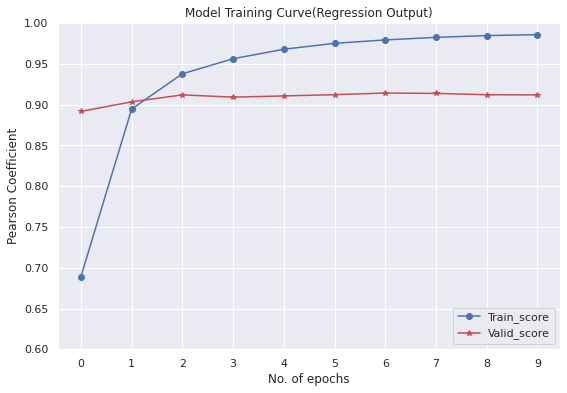

In [ ]:
#plot training and validation curve for Regression
import matplotlib.pyplot as plt
import seaborn as sns
train_score_reg = epochs_score_reg['train_Pearson_score'] # train_score
valid_score_reg = epochs_score_reg['val_Pearson_score'] # valid_score
 

sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score_reg ,'o-b', label= 'Train_score' )#plot train score
plt.plot(valid_score_reg, '*-r', label='Valid_score') # plot valid score
plt.xticks(range(0, 10, 1)) #set xlabel location
plt.title('Model Training Curve(Regression Output)') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0.6,1]) #set the ylabel limit
plt.legend(loc=4) #set label location
plt.show()


#### Evaluation

In [ ]:
#evaluate on test data 
test_loss_reg, test_Pearson_score_reg, test_Spearman_score_reg = model_eval(custom_model_reg, 
                                                                            test_data_loader_reg, 
                                                                            device, 
                                                                            loss_fn,
                                                                            model_type[0])
print(test_loss_reg, test_Pearson_score_reg, test_Spearman_score_reg)

0.01859163236275146 0.9011378373625223 0.8859287003278358


In [ ]:
#evaluate on dev data 
dev_loss_reg, dev_Pearson_score_reg, dev_Spearman_score_reg = model_eval(custom_model_reg, 
                                                                        dev_data_loader_reg, 
                                                                        device, 
                                                                        loss_fn,
                                                                        model_type[0])
print(dev_loss_reg, dev_Pearson_score_reg, dev_Spearman_score_reg)

0.01598502778785026 0.912845530614849 0.897061857003664


In [ ]:
%%time
#Training process start for regression output model
epochs_score_bertelctra = defaultdict(list) #store score from each epochs
val_score_bertelctra = 0 # validation score

for epoch in range(EPOCHS):
  print('Epoch {:}/{:}'.format(epoch + 1, EPOCHS))
  print('=='*5)
  print()
  
  #model training initiate
  train_loss_be, train_Pearson_score_be = model_train(custom_model_BertElectra, train_data_loader_reg, device, loss_fn, optimizer_BertElec, scheduler_BertElec, model_type[0])
  print('Train loss is: {}, train_Pearson_score is {}'.format(train_loss_be,train_Pearson_score_be))
  #store values
  epochs_score_bertelctra['train_loss'].append(train_loss_be) #train losss
  epochs_score_bertelctra['train_Pearson_score'].append(train_Pearson_score_be) # pearson correlation


  #model validatiaon initiate
  val_loss_be, val_Pearson_score_be, val_Spearman_score_be = model_eval(custom_model_BertElectra, dev_data_loader_reg, device, loss_fn, model_type[0])
  print('Validation loss is: {}, Validation_Pearson_score is {}'.format(val_loss_be, val_Pearson_score_be))
  print()
  #store values
  epochs_score_bertelctra['val_loss'].append(val_loss_be) #train losss
  epochs_score_bertelctra['val_Pearson_score'].append(val_Pearson_score_be) # pearson correlation
  epochs_score_bertelctra['val_Spearman_score'].append(val_Spearman_score_be) # Spearman correlation

  #save model with high validaiton score
  if val_Pearson_score_be >  val_score_bertelctra:
    val_score_bertelctra = val_Pearson_score_be
    torch.save(custom_model_BertElectra.state_dict(), 'BertElectra_reg_best_model.bin')

print()
print('Training completed......')


Epoch 1/10

Model is training based on regression ouput!!!
Train loss is: 0.053620093846176234, train_Pearson_score is 0.7373595120184019
Validation loss is: 0.027191743888753526, Validation_Pearson_score is 0.8635254272313446

Epoch 2/10

Model is training based on regression ouput!!!
Train loss is: 0.022851546056982544, train_Pearson_score is 0.8729085999626687
Validation loss is: 0.022707672403293088, Validation_Pearson_score is 0.8817603416858175

Epoch 3/10

Model is training based on regression ouput!!!
Train loss is: 0.01334459764669494, train_Pearson_score is 0.9317394488303402
Validation loss is: 0.024423532088861822, Validation_Pearson_score is 0.8783918995089054

Epoch 4/10

Model is training based on regression ouput!!!
Train loss is: 0.007975044652509193, train_Pearson_score is 0.9566414857927422
Validation loss is: 0.019007798730138133, Validation_Pearson_score is 0.887763307215896

Epoch 5/10

Model is training based on regression ouput!!!
Train loss is: 0.00538066012409

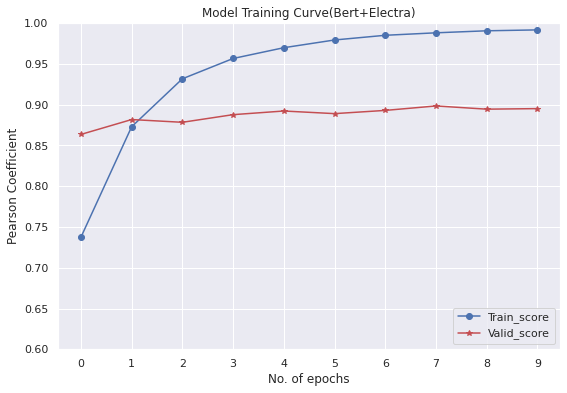

In [ ]:
#plot training and validation curve for Bert+Electra combined model
import matplotlib.pyplot as plt
import seaborn as sns
train_score_be = epochs_score_bertelctra['train_Pearson_score'] # train_score
valid_score_be = epochs_score_bertelctra['val_Pearson_score'] # valid_score
 

sns.set(style='darkgrid') #set plot style
sns.set(rc={'figure.figsize':(9,6)}) # set figure size
plt.plot(train_score_be ,'o-b', label= 'Train_score' )#plot train score
plt.plot(valid_score_be, '*-r', label='Valid_score') # plot valid score
plt.xticks(range(0, 10, 1)) #set xlabel location
plt.title('Model Training Curve(Bert+Electra)') #  title
plt.ylabel('Pearson Coefficient') # ylabel
plt.xlabel('No. of epochs') # xlabel
plt.ylim([0.6,1]) #set the ylabel limit
plt.legend(loc=4) #set label location
plt.show()


In [ ]:
#evaluate on test data 
test_loss_be, test_Pearson_score_be, test_Spearman_score_be = model_eval(custom_model_BertElectra, 
                                                                        test_data_loader_reg, 
                                                                        device, 
                                                                        loss_fn,
                                                                        model_type[0])
print(test_loss_be, test_Pearson_score_be, test_Spearman_score_be)


0.024075748249032032 0.8549361319865953 0.8238797900145182


In [ ]:
test_loss_be, test_Pearson_score_be, test_Spearman_score_be = model_eval(custom_model_BertElectra, 
                                                                        dev_data_loader_reg, 
                                                                        device, 
                                                                        loss_fn,
                                                                        model_type[0])
print(test_loss_be, test_Pearson_score_be, test_Spearman_score_be)

0.017782565087397048 0.8923963216053599 0.8734975231814652


In [ ]:
#show in pandas dataframe dev_Spearman_score
electra_df = pd.DataFrame( data=[['Electra-CosOutput', 0.805442073895768, 0.7810846984909834, 'Pearson',],
                    ['Electra-CosOutput',  0.7950363803486822,  0.7723773028372443, 'Spearman'],
                    ['Electra-RegOutput', 0.912845530614849, 0.9011378373625223, 'Pearson'],
                    ['Electra-RegOutput', 0.897061857003664, 0.8859287003278358, 'Spearman']
                    ], 
             columns=['Method-Types', 'DevSet', 'TestSet', 'Metric'])

#highlight the maximum in a column with yellow.
def highlight_max(val):
  
    is_max = val == val.max()
    return ['background-color: yellow' if v else '' for v in is_max]

electra_df.style.apply(highlight_max, subset=['DevSet', 'TestSet'])


#import plotly.figure_factory as ff 
#ff.create_table(electra_df)

,Method-Types,DevSet,TestSet,Metric
0,Electra-CosOutput,0.805442,0.781085,Pearson
1,Electra-CosOutput,0.795036,0.772377,Spearman
2,Electra-RegOutput,0.912846,0.901138,Pearson
3,Electra-RegOutput,0.897062,0.885929,Spearman


####Observation:
Electra-RegOuput i.e one regression layer on top of pretained-ELECTRA model gives higest result in both dataset(dev and test).

# Save and Load model

In [ ]:
#save model
#torch.save(custom_model.state_dict(), '/content/drive/My Drive/Google_Colab/Electra_best_model.bin')

In [ ]:
#load model and evaluate on test data
fine_tuned_model = ElectraSentenceSimilarityModelCos()
fine_tuned_model.load_state_dict(torch.load('/content/best_modElectra_best_model.bin'))
test_loss, test_Pearson_score = model_eval(
                                      fine_tuned_model.to(device),
                                      test_data_loader, 
                                      device, 
                                      loss_fn)
print(test_loss, test_Pearson_score)

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['electra.embeddings_project.weight', 'electra.embeddings_project.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.04113160383127544 0.7887276552132803


# References:
1. Chris McCormick and Nick Ryan. (2019, May 14). BERT Word Embeddings Tutorial. Retrieved from http://www.mccormickml.com , https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

2. [Sentiment Analysis with BERT](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=1zhHoFNsxufs&forceEdit=true&sandboxMode=true)

3. [Hugging Face Transformer](https://huggingface.co/transformers/)

4. [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)

5. [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)
